In [1]:
# Importing Libraries for Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)
from sklearn.impute import SimpleImputer

# Multicollinearity Check
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display plots inline
%matplotlib inline


In [2]:
# Load the processed dataset
data_path = 'dataset_FINAL_avg.csv'  # Update this path as needed
df = pd.read_csv(data_path)
df_predictions = df.copy()

print("Dataset Loaded Successfully!")
print(f"Shape of the dataset: {df.shape}\n")
print("First 5 rows of the dataset:")
display(df.head())


Dataset Loaded Successfully!
Shape of the dataset: (4519, 14)

First 5 rows of the dataset:


,employeeID,Tenure,Age,Performance,DeptFreqEncoded,RoleFreqEncoded,JobSatisfaction,OverTime,DistanceFromHome,YearsSinceLastPromotion,TrainingTimesLastYear,JobInvolvement,Turnover,avg_sentiment
0,1,0.085106,0.510638,0.374540,0.097367,0.093826,0.750790,0,0.022565,0.735718,0.8,0.045459,0,0.567469
1,2,0.000000,0.000000,0.950714,0.091613,0.097809,0.143866,0,0.861665,0.211717,0.4,0.838560,0,0.581199
2,3,0.000000,0.297872,0.731994,0.101350,0.099358,0.622060,0,0.577117,0.145286,0.6,0.989355,0,0.662175
3,4,0.042553,0.234043,0.598658,0.098473,0.094490,0.080323,1,0.890658,0.316292,0.6,0.472485,1,0.354309
4,5,0.042553,0.425532,0.156019,0.104669,0.094490,0.694622,1,0.596945,0.976071,0.2,0.969590,0,0.202792


In [3]:
# Drop 'employeeID' as it's not a feature
if 'employeeID' in df.columns:
    df = df.drop(columns=['employeeID'])
    print("\nDropped 'employeeID' column.")
else:
    print("\n'employeeID' column not found. Skipping drop.")

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from feature lists
if 'Turnover' in numerical_cols:
    numerical_cols.remove('Turnover')
if 'Turnover' in categorical_cols:
    categorical_cols.remove('Turnover')

print(f"\nNumerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")



Dropped 'employeeID' column.

Missing values in each column:
Tenure                     0
Age                        0
Performance                0
DeptFreqEncoded            0
RoleFreqEncoded            0
JobSatisfaction            0
OverTime                   0
DistanceFromHome           0
YearsSinceLastPromotion    0
TrainingTimesLastYear      0
JobInvolvement             0
Turnover                   0
avg_sentiment              0
dtype: int64

Numerical Columns: ['Tenure', 'Age', 'Performance', 'DeptFreqEncoded', 'RoleFreqEncoded', 'JobSatisfaction', 'OverTime', 'DistanceFromHome', 'YearsSinceLastPromotion', 'TrainingTimesLastYear', 'JobInvolvement', 'avg_sentiment']
Categorical Columns: []


In [4]:
# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define features (X) and target (y)
X = df.drop(columns=['Turnover'])  # Features
y = df['Turnover']  # Target variable

print("\nFeatures and target defined.")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")



Features and target defined.
Features shape: (4519, 12)
Target shape: (4519,)


In [5]:
# Split the data into training and testing sets (80-20 split) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Data split into training and testing sets.
Training set shape: (3615, 12)
Testing set shape: (904, 12)


In [6]:
# Check class distribution in training set
print("\nClass distribution in training set:")
print(y_train.value_counts())



Class distribution in training set:
Turnover
0    2423
1    1192
Name: count, dtype: int64


In [7]:
# Initialize the Logistic Regression model with class_weight='balanced'
logreg = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')

# Create a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

print("\nPipeline created.")



Pipeline created.


In [8]:
# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the resampled training data
grid_search.fit(X_train, y_train)

print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters from GridSearchCV:
{'classifier__C': 0.01, 'classifier__penalty': 'l2'}


In [9]:
# Use the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")



Model Evaluation Metrics:
Accuracy: 0.8274
ROC AUC Score: 0.8610


In [10]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       606
           1       0.70      0.84      0.76       298

    accuracy                           0.83       904
   macro avg       0.81      0.83      0.81       904
weighted avg       0.84      0.83      0.83       904




Confusion Matrix:
[[497 109]
 [ 47 251]]


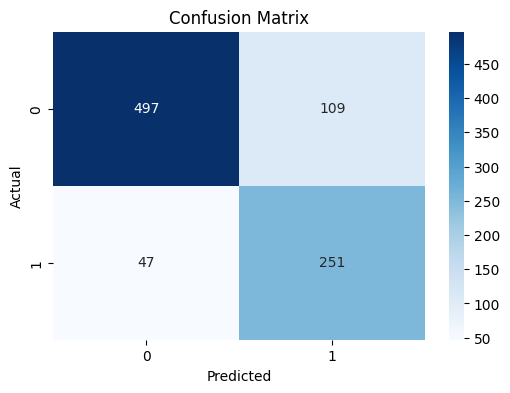

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
# Extract the preprocessed feature names
preprocessor.fit(X_train, y_train)
if categorical_cols:
    cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
else:
    cat_features = []
feature_names = numerical_cols + list(cat_features)

# Get coefficients from the logistic regression model
coefficients = best_model.named_steps['classifier'].coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['Odds Ratio'] = np.exp(feature_importance['Coefficient'])

# Sort by absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
feature_importance = feature_importance.drop(columns=['Abs_Coefficient'])

print("\nFeature Importance with Odds Ratios:")
display(feature_importance)



Feature Importance with Odds Ratios:


,Feature,Coefficient,Odds Ratio
11,avg_sentiment,-1.263660,0.282618
6,OverTime,0.168346,1.183346
3,DeptFreqEncoded,-0.079963,0.923150
1,Age,-0.024759,0.975545
2,Performance,0.021896,1.022138
5,JobSatisfaction,0.012063,1.012136
8,YearsSinceLastPromotion,0.008903,1.008943
0,Tenure,-0.007024,0.993001
9,TrainingTimesLastYear,0.005714,1.005731
10,JobInvolvement,0.005015,1.005028


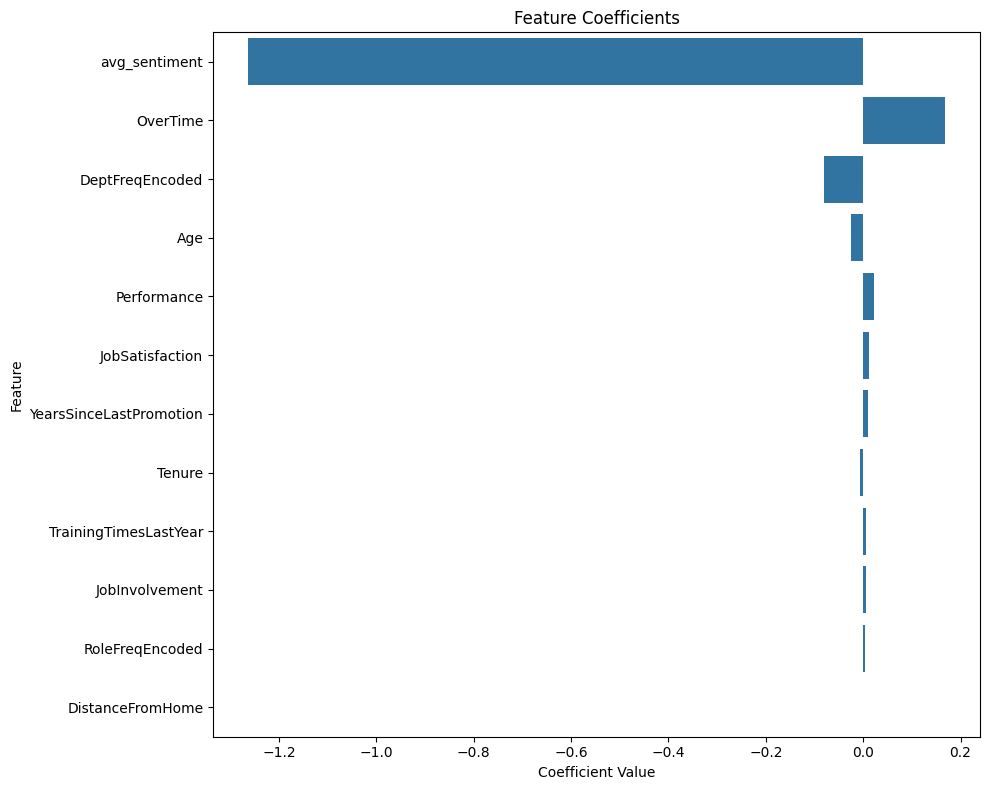

In [13]:
# Plot Feature Coefficients
plt.figure(figsize=(10,8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


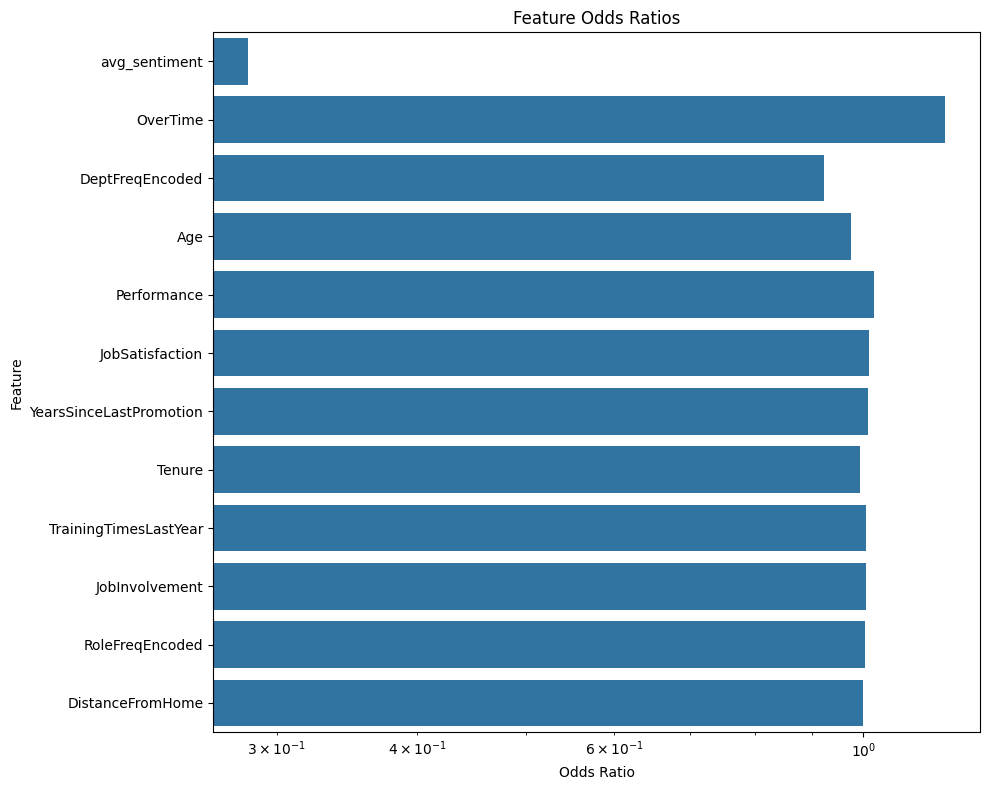

In [14]:
# Plot Odds Ratios
plt.figure(figsize=(10,8))
sns.barplot(x='Odds Ratio', y='Feature', data=feature_importance)
plt.title('Feature Odds Ratios')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.xscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()


In [15]:
# For VIF calculation, we need the numerical features only
# Refit preprocessor to get the transformed training data
X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(
    X_train_preprocessed, 
    columns=feature_names
)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_preprocessed.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train_preprocessed.values, i) 
    for i in range(X_train_preprocessed.shape[1])
]

print("\nVariance Inflation Factor (VIF) for each feature:")
display(vif_data.sort_values(by='VIF', ascending=False))



Variance Inflation Factor (VIF) for each feature:


,Feature,VIF
0,Tenure,1.771528
1,Age,1.769292
6,OverTime,1.139942
11,avg_sentiment,1.139390
7,DistanceFromHome,1.005608
5,JobSatisfaction,1.003535
3,DeptFreqEncoded,1.003467
4,RoleFreqEncoded,1.003443
10,JobInvolvement,1.003198
9,TrainingTimesLastYear,1.002895


In [16]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print("\n5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())



5-Fold Cross-Validation Accuracy Scores: [0.79535398 0.80309735 0.78650442 0.81526549 0.79955703]
Mean CV Accuracy: 0.799955654210645


In [17]:
import joblib

# Save the best model to a pickle file
model_filename = 'best_model.pkl'
joblib.dump(best_model, model_filename)

print(f"Model saved as {model_filename}")

Model saved as best_model.pkl


In [18]:
# Ensure we use the full dataset (df) for predictions
turnover_probabilities_all = best_model.predict_proba(X)[:, 1]  # Probability of turnover
turnover_predictions_all = best_model.predict(X)  # Binary predictions (0 or 1)

# Add predictions and 'employeeID' back to the DataFrame
df_predictions['Turnover_Likelihood'] = turnover_probabilities_all
df_predictions['Turnover_Prediction'] = turnover_predictions_all

# Export the entire dataset with predictions to a CSV file
df_predictions[['employeeID', 'Turnover_Likelihood', 'Turnover_Prediction']].to_csv('turnovers_full.csv', index=False)

print("Turnover predictions for all employees saved to 'turnovers_full.csv'!")


Turnover predictions for all employees saved to 'turnovers_full.csv'!


In [19]:
# Load the CSV file
file_path = 'turnovers_full.csv'  # Replace with your actual file path
df_risks = pd.read_csv(file_path)

# Drop the Turnover_Prediction column
if 'Turnover_Prediction' in df_risks.columns:
    df_risks = df_risks.drop(columns=['Turnover_Prediction'])
    print("'Turnover_Prediction' column dropped.")

# Modify Turnover_Likelihood: multiply by 100, round it, and rename it to 'riskScore'
if 'Turnover_Likelihood' in df_risks.columns:
    df_risks['riskScore'] = (df_risks['Turnover_Likelihood'] * 100).round()
    print("'Turnover_Likelihood' converted to 'riskScore'.")

# Add the 'riskLevel' column based on 'riskScore'
def determine_risk_level(score):
    if 0 <= score <= 20:
        return 'low'
    elif 20 < score <= 40:
        return 'medium'
    else:
        return 'high'

df_risks['riskLevel'] = df_risks['riskScore'].apply(determine_risk_level)
print("'riskLevel' column added based on 'riskScore'.")

# Save the modified DataFrame to a new CSV file
output_path = 'processed_turnovers.csv'  # Replace with your desired output file name
df_risks.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")

# Display the first few rows of the modified DataFrame for verification
print("\nModified DataFrame:")
print(df_risks.head())


'Turnover_Prediction' column dropped.
'Turnover_Likelihood' converted to 'riskScore'.
'riskLevel' column added based on 'riskScore'.
Processed data saved to processed_turnovers.csv

Modified DataFrame:
   employeeID  Turnover_Likelihood  riskScore riskLevel
0           1             0.399761       40.0    medium
1           2             0.414775       41.0      high
2           3             0.268904       27.0    medium
3           4             0.769083       77.0      high
4           5             0.882593       88.0      high
